# DeepWalk

### Load dataset

In [112]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from matplotlib import pyplot as plt 
np.random.seed(15)


#Load data
adjlist = nx.read_adjlist("./data/karate_club.adjlist", nodetype=int)
karate_label = np.loadtxt("./data/karate_label.txt")
Graph = nx.read_adjlist("./data/karate_club.adjlist", nodetype=int)
node_number = nx.to_pandas_adjacency(Graph).columns


adj = nx.to_numpy_array(adjlist)
#label = karate_label[:,-1]

print(adj.shape)
#print(label.shape)

(34, 34)


### Activation function


In [113]:
def softmax(x):
    c = np.max(x)
    b = x-c
    exp_x = np.exp(b)
    sum_exp_x = np.sum(exp_x)
    y = exp_x / sum_exp_x
    return y

### FC layer, Random walk 

In [114]:
#Fully connected layer
class ann:
    def __init__(self, input_size, hidden_size, output_size):
        # setting the shape of the layer and putting random inital value
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)

    # Calculating the Values
    def gradient(self, x, y):
        # forward
        W1, W2 = self.params['W1'], self.params['W2']
        h = np.dot(x, W1)
        # H = softmax(U)

        U2 = np.dot(h, W2)
        Y = softmax(U2)

        diff = (Y - y)  # 34*1

        ERR2 = np.outer(h, diff)

        # backpropagation
        # ERR2 = (-np.log(np.abs(Y-y)))*Y*(1-Y)
        ERR = np.outer(x, np.dot(W2, diff))

        return ERR, ERR2, diff, Y

w = 3 #window_size w
d = 4 #embedding size d
r = 10 # walks per vertex
t = 10 # walk length
learning_rate = 0.0001

#Params
n_network = ann(input_size = 34,hidden_size = d,output_size = 34)
#P = np.random.random((34,d)) # Work as W1 (input_size,hidden_size)
#Q = np.random.random((d,34)) # work as W2 (hidden_size, input_size)

def random_walk(vertex, t):
    ans = []
    ans.append(vertex)

    while True:
        # stop untill the window size get t
        if len(ans) == t:
            return ans

        # check nearest vertexs
        vertex_adj_list = list(adj[vertex])
        near_vertex_index = np.nonzero(vertex_adj_list)

        # choose the nearess vertex randomly
        get_vertex = np.random.choice(list(near_vertex_index[0]), 1)
        ans.append(get_vertex[0])
        vertex = get_vertex[0]


def skipgram(W, w, loss):
    new_loss = np.zeros(34)
    loss = 0
    for idx, vertex in enumerate(W):
        # making u_list considering w
        start = idx - w
        end = idx + w
        if start < 0:
            start = 0
        if end >= len(W):
            end = len(W) - 1

        u_list = []
        u_list.extend(W[start:idx])
        u_list.extend(W[idx + 1:end + 1])

        # calculating each u from u_list
        for each_u in u_list:
            # input, ouput with one-hot encoding
            input_vertex = np.zeros(34)
            y_pred = np.zeros(34)
            v = vertex
            u = each_u
            input_vertex[v] = 1
            y_pred[u] = 1

            # gradient (forward,backpropa)

            ERR, ERR2, diff, Y = n_network.gradient(input_vertex, y_pred)
            # updata params
            n_network.params['W1'] -= learning_rate * ERR
            n_network.params['W2'] -= learning_rate * ERR2
            # n_network.params['W2'] -= np.reshape(learning_rate * ERR2 * H.T, (d,34))

            # calculating loss
            loss += -np.log(Y[each_u])
        # new_loss = new_loss / len(u_list)
    return loss


epoch = 100
epoch_loss2 = []
loss = np.zeros((34, 34))
for _ in range(epoch):
    epoch_loss = 0
    for i in range(r):
        O = np.arange(34)
        np.random.shuffle(O)

        for vertex in O:
            W = random_walk(vertex, t)
            loss = skipgram(W, w, loss)
            epoch_loss += (loss / len(W))

    # h = np.dot(adj[1],W1)
    # H = softmax(U)

    # U2 = np.dot(h,W2)
    # Y = softmax(U2)
    # aa = np.mean(-np.log(Y -adj[1]))
    epoch_loss2.append(np.mean(epoch_loss) / (len(O) * r))
    # calculating loss
    # n_network.params['W1']


### Visualize random walk with t-SNE

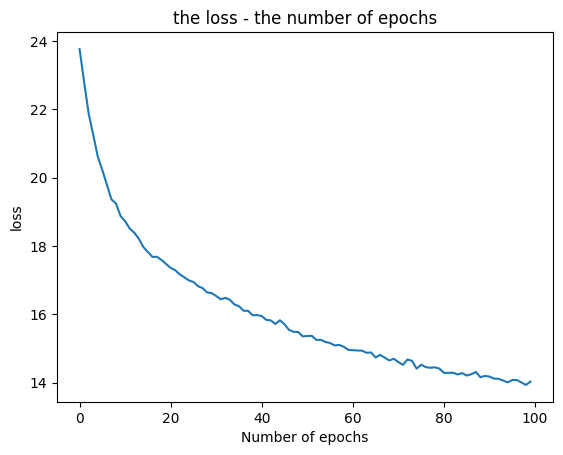

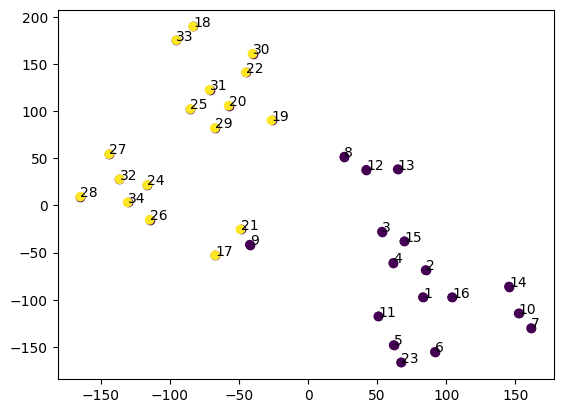

In [115]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

plt.plot(epoch_loss2)
plt.title("the loss - the number of epochs")
plt.xlabel("Number of epochs")
plt.ylabel("loss")
plt.show()

nums = np.identity(34)
W1 = n_network.params['W1']
output = np.dot(nums , W1)
adj = nx.to_numpy_array(adjlist)
label = karate_label[:,-1]


node_number
label
label_fix = []
for i in node_number:
    tem = label[i]
    label_fix.append(tem)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = TSNE(learning_rate=100,perplexity=5)
transformed = model.fit_transform(output)
xs = transformed[:,0]
ys = transformed[:,1]

for i in range(len(xs)):
    plt.scatter(xs[i],ys[i],c = node_number[i])
    plt.text(xs[i],ys[i],i+1)
plt.scatter(xs,ys,c=label_fix)
#plt.text(xs,ys)
plt.show()

# node2vec

### Random walk

In [116]:
import random
from tqdm import tqdm

# Generate random walks on the graph
def parallel_generate_walks(d_graph: dict, global_walk_length: int, num_walks: int, cpu_num: int,
                            sampling_strategy: dict = None, num_walks_key: str = None, walk_length_key: str = None,
                            neighbors_key: str = None, probabilities_key: str = None, first_travel_key: str = None,
                            quiet: bool = False) -> list:
    """
    Generates the random walks which will be used as the skip-gram input.

    :return: List of walks. Each walk is a list of nodes.
    """

    walks = list()

    if not quiet:
        pbar = tqdm(total=num_walks, desc='Generating walks (CPU: {})'.format(cpu_num))

    for n_walk in range(num_walks):

        # Update progress bar
        if not quiet:
            pbar.update(1)

        # Shuffle the nodes
        shuffled_nodes = list(d_graph.keys())
        random.shuffle(shuffled_nodes)

        # Start a random walk from every node
        for source in shuffled_nodes:

            # Skip nodes with specific num_walks
            if source in sampling_strategy and \
                    num_walks_key in sampling_strategy[source] and \
                    sampling_strategy[source][num_walks_key] <= n_walk:
                continue

            # Start walk
            walk = [source]

            # Calculate walk length
            if source in sampling_strategy:
                walk_length = sampling_strategy[source].get(walk_length_key, global_walk_length)
            else:
                walk_length = global_walk_length

            # Perform walk
            while len(walk) < walk_length:

                walk_options = d_graph[walk[-1]].get(neighbors_key, None)

                # Skip dead end nodes
                if not walk_options:
                    break

                if len(walk) == 1:  # For the first step
                    probabilities = d_graph[walk[-1]][first_travel_key]
                    walk_to = random.choices(walk_options, weights=probabilities)[0]
                else:
                    probabilities = d_graph[walk[-1]][probabilities_key][walk[-2]]
                    walk_to = random.choices(walk_options, weights=probabilities)[0]

                walk.append(walk_to)

            walk = list(map(str, walk))  # Convert all to strings

            walks.append(walk)

    if not quiet:
        pbar.close()

    return walks

In [117]:
from importlib.metadata import version

def is_dated_gensim_version():
    return version("gensim") < '4.0.0'

### Create Node2Vec

In [118]:
import os
import random
from collections import defaultdict

import gensim
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm



class Node2Vec:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight'
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'

    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', workers: int = 1, sampling_strategy: dict = None,
                 quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Node2Vec object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
        :param seed: Seed for the random number generator.
        Use these keys exactly. If not set, will use the global ones which were passed on the object initialization
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        for source in nodes_generator:

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    try:
                        if self.graph[current_node][destination].get(self.weight_key):
                            weight = self.graph[current_node][destination].get(self.weight_key, 1)
                        else: 
                            ## Example : AtlasView({0: {'type': 1, 'weight':0.1}})- when we have edge weight
                            edge = list(self.graph[current_node][destination])[-1]
                            weight = self.graph[current_node][destination][edge].get(self.weight_key, 1)
                            
                    except:
                        weight = 1 
                    
                    if destination == source:  # Backwards probability
                        ss_weight = weight * 1 / p
                    elif destination in self.graph[source]:  # If the neighbor is connected to the source
                        ss_weight = weight
                    else:
                        ss_weight = weight * 1 / q

                    # Assign the unnormalized sampling strategy weight, normalize during random walk
                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Normalize
                unnormalized_weights = np.array(unnormalized_weights)
                d_graph[current_node][self.PROBABILITIES_KEY][
                    source] = unnormalized_weights / unnormalized_weights.sum()

            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            first_travel_weights = np.array(first_travel_weights)
            d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(parallel_generate_walks)(self.d_graph,
                                             self.walk_length,
                                             len(num_walks),
                                             idx,
                                             self.sampling_strategy,
                                             self.NUM_WALKS_KEY,
                                             self.WALK_LENGTH_KEY,
                                             self.NEIGHBORS_KEY,
                                             self.PROBABILITIES_KEY,
                                             self.FIRST_TRAVEL_KEY,
                                             self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Node2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        size = 'size' if is_dated_gensim_version() else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'sg' not in skip_gram_params:
            skip_gram_params['sg'] = 1

        return gensim.models.Word2Vec(self.walks, **skip_gram_params)

### Run Node2Vec to generate embeddings 

In [119]:
# Load the Karate Club graph
G = nx.karate_club_graph()

# Initialize Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

# Fit the model to the data
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get the embedding of each node
node_embeddings = model.wv.vectors

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 641.62it/s]


### Visualize Node2Vec embeddings

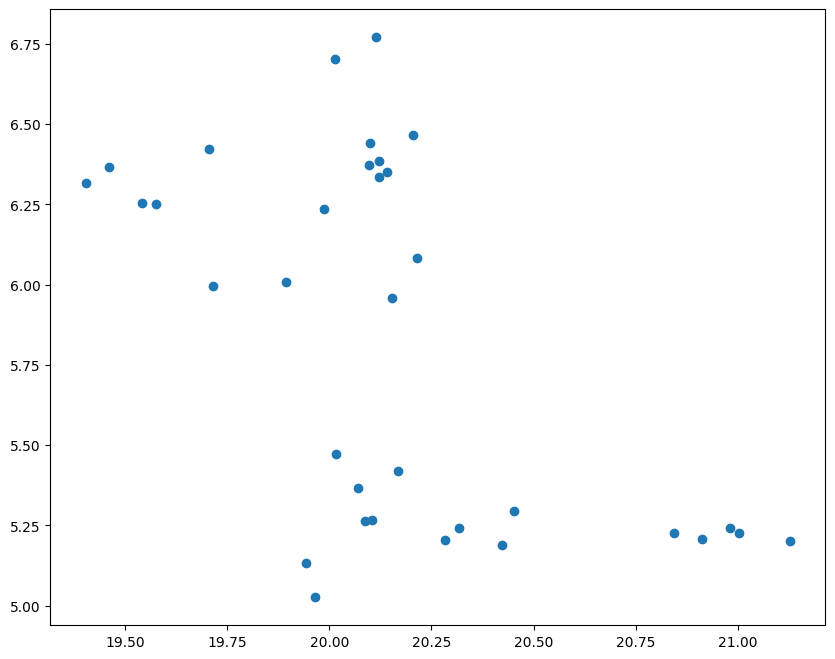

In [120]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Use t-SNE to reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])
plt.show()

# node2vec+

In [121]:
import os
import random
from collections import defaultdict

import gensim
import networkx as nx
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm


class Node2VecPlus:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight'
    EDGE_FEATURES_KEY = 'edge_features'  # Main difference
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'

    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, weight_key: str = 'weight', edge_features_key: str = None, workers: int = 1,
                 sampling_strategy: dict = None, quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Node2VecPlus object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param edge_features_key: Key for edge features if any (default: None)
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'
        :param seed: Seed for the random number generator
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.weight_key = weight_key
        self.edge_features_key = edge_features_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)
        self.E = 1e-7

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node, including edge features.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        def calculate_normalized_weights(graph, y, E):
            normalized_weights = {}
            for v in graph.nodes():
                for u in graph.neighbors(v):
                    edge_weights = [graph[v][u].get('weight', 1) for u in graph.neighbors(v)]
                    mean_weight = np.mean(edge_weights)
                    std_weight = np.std(edge_weights)
                    a_v = mean_weight + y * std_weight
                    w_vu = graph[v][u].get('weight', 1)
                    wy_vu = w_vu / max(a_v, E)
                    normalized_weights[(v, u)] = wy_vu
                    normalized_weights[(u, v)] = wy_vu 
            return normalized_weights

        y = 1
        for source in nodes_generator:
            normalized_weights = calculate_normalized_weights(self.graph, y, self.E)

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    try:
                        if self.graph[current_node][destination].get(self.weight_key):
                            weight = self.graph[current_node][destination].get(self.weight_key, 1)
                        else:
                            # Handle different graph data structures with edge weights
                            edge = list(self.graph[current_node][destination])[-1]
                            weight = self.graph[current_node][destination][edge].get(self.weight_key, 1)
                    except:
                        weight = 1

                    # Calculate bias factor
                    if destination == source:  # Case 1: 1/p
                        ss_weight = 1 / p
                    elif normalized_weights.get((destination, source), 0) >= 1:  # Case 2: 1
                        ss_weight = 1
                    elif normalized_weights.get((destination, source), 0) < 1 and normalized_weights.get((source, destination), 0) < 1:  # Case 3: min{1,1/q}
                        ss_weight = min(1, 1 / q)
                    elif normalized_weights.get((destination, source), 0) < 1 and normalized_weights.get((source, destination), 0) >= 1:  # Case 4: 1/q + (1 - 1/q)*normalized of edge weight
                        ss_weight = 1 / q + (1 - 1 / q) * normalized_weights.get((destination, source), 1)

                    # Incorporate edge features if provided
                    if self.edge_features_key:
                        edge_features = self.graph[current_node][destination].get(self.edge_features_key, 1)
                        ss_weight *= edge_features

                    # Assign the unnormalized sampling strategy weight, normalize during random walk
                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Normalize
                if unnormalized_weights:
                    unnormalized_weights = np.array(unnormalized_weights)
                    d_graph[current_node][self.PROBABILITIES_KEY][
                        source] = unnormalized_weights / unnormalized_weights.sum()

            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            if first_travel_weights:
                first_travel_weights = np.array(first_travel_weights)
                d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(self._parallel_generate_walks)(self.d_graph,
                                                   self.walk_length,
                                                   len(num_walks),
                                                   idx,
                                                   self.sampling_strategy,
                                                   self.NUM_WALKS_KEY,
                                                   self.WALK_LENGTH_KEY,
                                                   self.NEIGHBORS_KEY,
                                                   self.PROBABILITIES_KEY,
                                                   self.FIRST_TRAVEL_KEY,
                                                   self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks

    def _parallel_generate_walks(self, d_graph, walk_length, num_walks, idx, sampling_strategy,
                                 NUM_WALKS_KEY, WALK_LENGTH_KEY, NEIGHBORS_KEY, PROBABILITIES_KEY, FIRST_TRAVEL_KEY, quiet):
        """
        Helper function to generate walks in parallel.
        """
        walks = []
        for _ in tqdm(range(num_walks), desc=f'Generating walks (worker {idx})', disable=quiet):
            for node in d_graph:
                walk = [node]
                while len(walk) < walk_length:
                    cur = walk[-1]
                    cur_nbrs = d_graph[cur][NEIGHBORS_KEY]
                    if len(walk) == 1:
                        walk.append(np.random.choice(cur_nbrs, p=d_graph[cur][FIRST_TRAVEL_KEY]))
                    else:
                        prev = walk[-2]
                        next_node = np.random.choice(cur_nbrs, p=d_graph[cur][PROBABILITIES_KEY][prev])
                        walk.append(next_node)
                walks.append(walk)
        return walks

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Node2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        size = 'size' if gensim.__version__ < '4.0.0' else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'seed' not in skip_gram_params and hasattr(self, 'seed'):
            skip_gram_params['seed'] = self.seed

        model = gensim.models.Word2Vec(sentences=self.walks, **skip_gram_params)
        return model

### Run Div2Vec to generate embeddings 

In [122]:
# Example usage
G = nx.karate_club_graph()
node2vecplus = Node2VecPlus(G, dimensions=64, walk_length=30, num_walks=200, workers=4, edge_features_key=1)
model = node2vecplus.fit(window=10, min_count=1, batch_words=4)

# Get the embedding of each node
node_embeddings = model.wv.vectors

Generating walks (worker 2): 100%|██████████| 50/50 [00:00<00:00, 149.51it/s]


### Visualize Node2VecPlus embedding

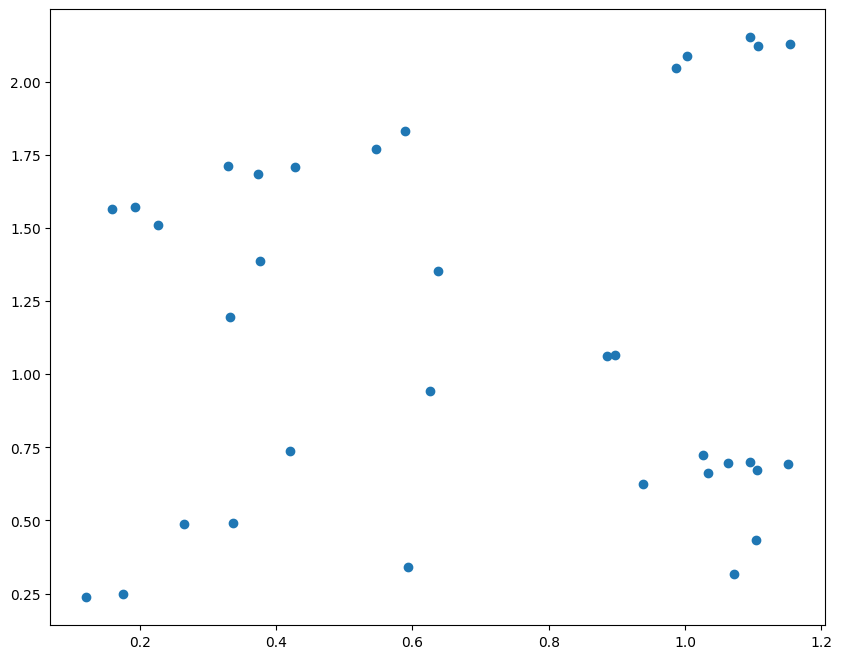

In [123]:
# Use t-SNE to reduce the dimensionality of the embeddings to 2D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])
plt.show()

# Walklets

### Random walk and Walklets

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the random_walk and generate_walklets functions
def random_walk(G, node, walk_length):
    walk = [node]
    for _ in range(walk_length - 1):
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) > 0:
            walk.append(random.choice(neighbors))
        else:
            break
    return walk

def generate_walklets(G, walk_length, num_walks, window_size):
    walklets = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = random_walk(G, node, walk_length)
            for i in range(len(walk) - window_size + 1):
                for j in range(1, window_size):
                    walklets.append((walk[i], walk[i+j]))
    return walklets

### Regresssion with walklets

In [125]:
# Generate walklets
walklets = generate_walklets(G, walk_length=5, num_walks=10, window_size=3)

# Create a dictionary to store the features of each node
features = {node: [0]*len(G.nodes()) for node in G.nodes()}

# Update the features based on the walklets
for node1, node2 in walklets:
    features[node1][node2] += 1
    features[node2][node1] += 1

karate_label = np.loadtxt("./data/karate_label.txt")

# Create a list of feature vectors and a list of labels
X = list(features.values())
y = karate_label[:,1]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7142857142857143


### Visualize confusion matrix

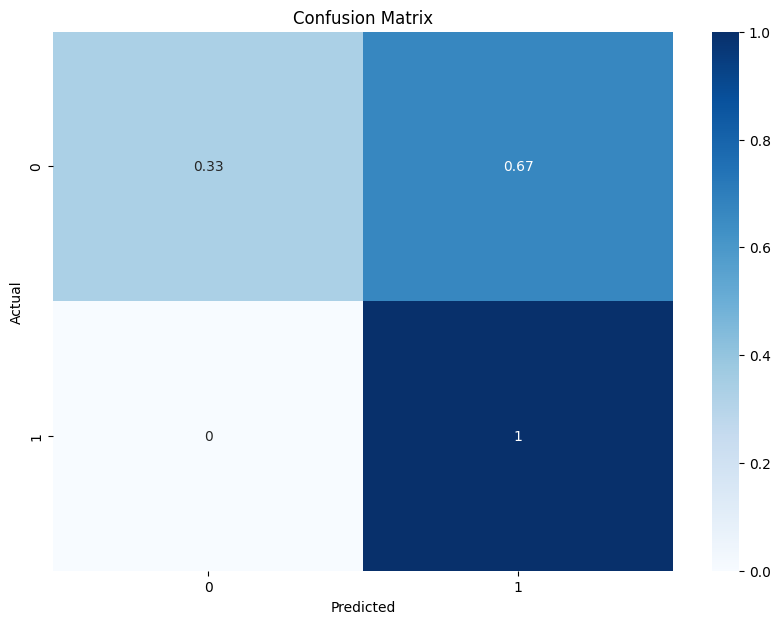

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])

# Create a heatmap from the DataFrame
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Div2vec

In [127]:
class Div2Vec:
    FIRST_TRAVEL_KEY = 'first_travel_key'
    PROBABILITIES_KEY = 'probabilities'
    NEIGHBORS_KEY = 'neighbors'
    WEIGHT_KEY = 'weight' #Main difference
    NUM_WALKS_KEY = 'num_walks'
    WALK_LENGTH_KEY = 'walk_length'
    P_KEY = 'p'
    Q_KEY = 'q'
    DIVERSITY_FACTOR_KEY = 'diversity_factor' #Main difference

    # Initialize the Div2Vec object, precompute walking probabilities, and generate the walks
    def __init__(self, graph: nx.Graph, dimensions: int = 128, walk_length: int = 80, num_walks: int = 10, p: float = 1,
                 q: float = 1, diversity_factor: float = 1.0, weight_key: str = 'weight', workers: int = 1, 
                 sampling_strategy: dict = None, quiet: bool = False, temp_folder: str = None, seed: int = None):
        """
        Initiates the Div2Vec object, precomputes walking probabilities and generates the walks.

        :param graph: Input graph
        :param dimensions: Embedding dimensions (default: 128)
        :param walk_length: Number of nodes in each walk (default: 80)
        :param num_walks: Number of walks per node (default: 10)
        :param p: Return hyper parameter (default: 1)
        :param q: Inout parameter (default: 1)
        :param diversity_factor: Factor to penalize revisits within the same walk (default: 1.0)
        :param weight_key: On weighted graphs, this is the key for the weight attribute (default: 'weight')
        :param workers: Number of workers for parallel execution (default: 1)
        :param sampling_strategy: Node specific sampling strategies, supports setting node specific 'q', 'p', 'num_walks' and 'walk_length'.
        :param seed: Seed for the random number generator.
        :param temp_folder: Path to folder with enough space to hold the memory map of self.d_graph (for big graphs); to be passed joblib.Parallel.temp_folder
        """

        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.diversity_factor = diversity_factor
        self.weight_key = weight_key
        self.workers = workers
        self.quiet = quiet
        self.d_graph = defaultdict(dict)

        if sampling_strategy is None:
            self.sampling_strategy = {}
        else:
            self.sampling_strategy = sampling_strategy

        self.temp_folder, self.require = None, None
        if temp_folder:
            if not os.path.isdir(temp_folder):
                raise NotADirectoryError("temp_folder does not exist or is not a directory. ({})".format(temp_folder))

            self.temp_folder = temp_folder
            self.require = "sharedmem"

        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self._precompute_probabilities()
        self.walks = self._generate_walks()

    # Precompute transition probabilities for each node in the graph. Calculate unnormalized weights for each destination node and normalize them
    def _precompute_probabilities(self):
        """
        Precomputes transition probabilities for each node.
        """

        d_graph = self.d_graph

        nodes_generator = self.graph.nodes() if self.quiet \
            else tqdm(self.graph.nodes(), desc='Computing transition probabilities')

        for source in nodes_generator:

            # Init probabilities dict for first travel
            if self.PROBABILITIES_KEY not in d_graph[source]:
                d_graph[source][self.PROBABILITIES_KEY] = dict()

            for current_node in self.graph.neighbors(source):

                # Init probabilities dict
                if self.PROBABILITIES_KEY not in d_graph[current_node]:
                    d_graph[current_node][self.PROBABILITIES_KEY] = dict()

                unnormalized_weights = list()
                d_neighbors = list()

                # Calculate unnormalized weights
                for destination in self.graph.neighbors(current_node):

                    p = self.sampling_strategy[current_node].get(self.P_KEY,
                                                                 self.p) if current_node in self.sampling_strategy else self.p
                    q = self.sampling_strategy[current_node].get(self.Q_KEY,
                                                                 self.q) if current_node in self.sampling_strategy else self.q

                    try:
                        if self.graph[current_node][destination].get(self.weight_key):
                            weight = self.graph[current_node][destination].get(self.weight_key, 1)
                        else: 
                            # Handle different graph data structures with edge weights
                            edge = list(self.graph[current_node][destination])[-1]
                            weight = self.graph[current_node][destination][edge].get(self.weight_key, 1)
                    except:
                        weight = 1
                    
                    # Calculate the degree of the destination node
                    degree = self.graph.degree(destination)
                    
                    # Use the degree-based function for the weight
                    ss_weight = 1 / degree

                    unnormalized_weights.append(ss_weight)
                    d_neighbors.append(destination)

                # Probability choose next node
                unnormalized_weights = np.array(unnormalized_weights)
                d_graph[current_node][self.PROBABILITIES_KEY][
                    source] = unnormalized_weights / unnormalized_weights.sum()


            # Calculate first_travel weights for source
            first_travel_weights = []

            for destination in self.graph.neighbors(source):
                first_travel_weights.append(self.graph[source][destination].get(self.weight_key, 1))

            first_travel_weights = np.array(first_travel_weights)
            d_graph[source][self.FIRST_TRAVEL_KEY] = first_travel_weights / first_travel_weights.sum()

            # Save neighbors
            d_graph[source][self.NEIGHBORS_KEY] = list(self.graph.neighbors(source))

    def _generate_walks(self) -> list:
        """
        Generates the random walks which will be used as the skip-gram input.
        :return: List of walks. Each walk is a list of nodes.
        """

        flatten = lambda l: [item for sublist in l for item in sublist]

        # Split num_walks for each worker
        num_walks_lists = np.array_split(range(self.num_walks), self.workers)

        walk_results = Parallel(n_jobs=self.workers, temp_folder=self.temp_folder, require=self.require)(
            delayed(self._parallel_generate_walks)(self.d_graph,
                                                   self.walk_length,
                                                   len(num_walks),
                                                   idx,
                                                   self.sampling_strategy,
                                                   self.NUM_WALKS_KEY,
                                                   self.WALK_LENGTH_KEY,
                                                   self.NEIGHBORS_KEY,
                                                   self.PROBABILITIES_KEY,
                                                   self.FIRST_TRAVEL_KEY,
                                                   self.diversity_factor,
                                                   self.quiet) for
            idx, num_walks
            in enumerate(num_walks_lists, 1))

        walks = flatten(walk_results)

        return walks

    def _parallel_generate_walks(self, d_graph, walk_length, num_walks, idx, sampling_strategy, 
                                 NUM_WALKS_KEY, WALK_LENGTH_KEY, NEIGHBORS_KEY, PROBABILITIES_KEY, 
                                 FIRST_TRAVEL_KEY, diversity_factor, quiet):
        """
        Helper function to generate walks in parallel.
        """
        walks = []
        for _ in tqdm(range(num_walks), desc=f'Generating walks (worker {idx})', disable=quiet):
            for node in d_graph:
                walk = [node]
                while len(walk) < walk_length:
                    cur = walk[-1]
                    cur_nbrs = d_graph[cur][NEIGHBORS_KEY]
                    if len(walk) == 1:
                        next_node = np.random.choice(cur_nbrs, p=d_graph[cur][FIRST_TRAVEL_KEY])
                    else:
                        prev = walk[-2]
                        probabilities = d_graph[cur][PROBABILITIES_KEY][prev]
                        if diversity_factor < 1.0:
                            # Penalize already visited nodes to promote diversity
                            probabilities = self._apply_diversity_penalty(probabilities, cur_nbrs, walk, diversity_factor)
                        next_node = np.random.choice(cur_nbrs, p=probabilities)
                    walk.append(next_node)
                walks.append(walk)
        return walks

    def _apply_diversity_penalty(self, probabilities, neighbors, walk, diversity_factor):
        """
        Applies a penalty to the probabilities of nodes that have already been visited in the current walk.
        """
        visit_counts = defaultdict(int)
        for node in walk:
            visit_counts[node] += 1

        penalized_probabilities = np.array(probabilities)
        for i, neighbor in enumerate(neighbors):
            if visit_counts[neighbor] > 0:
                penalized_probabilities[i] *= (diversity_factor ** visit_counts[neighbor])

        penalized_probabilities /= penalized_probabilities.sum()
        return penalized_probabilities

    def fit(self, **skip_gram_params) -> gensim.models.Word2Vec:
        """
        Creates the embeddings using gensim's Word2Vec.
        :param skip_gram_params: Parameters for gensim.models.Word2Vec - do not supply 'size' / 'vector_size' it is
            taken from the Div2Vec 'dimensions' parameter
        :type skip_gram_params: dict
        :return: A gensim word2vec model
        """

        if 'workers' not in skip_gram_params:
            skip_gram_params['workers'] = self.workers

        # Figure out gensim version, naming of output dimensions changed from size to vector_size in v4.0.0
        size = 'size' if gensim.__version__ < '4.0.0' else 'vector_size'
        if size not in skip_gram_params:
            skip_gram_params[size] = self.dimensions

        if 'seed' not in skip_gram_params and hasattr(self, 'seed'):
            skip_gram_params['seed'] = self.seed

        model = gensim.models.Word2Vec(sentences=self.walks, **skip_gram_params)
        return model

### Generating random walk and run Div2Vec to generate embeddings 


In [128]:
div2vec = Div2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4, diversity_factor=0.5)

# Fit the model to the data
model = div2vec.fit(window=10, min_count=1, batch_words=4)

# Get the embedding of each node
node_embeddings = model.wv.vectors


Generating walks (worker 4): 100%|██████████| 50/50 [00:00<00:00, 88.89it/s]


### Visualize embeddings 

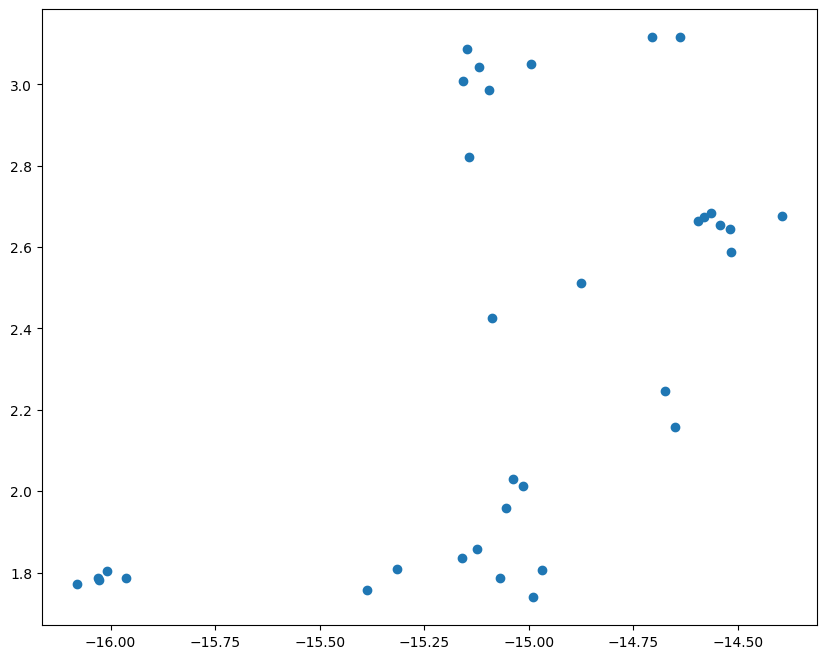

In [129]:
# Use t-SNE to reduce the dimensionality of the embeddings to 2D
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1])
plt.show()